## Outline
1. Define Task
2. Data Preprocessing
3. Build LSTM model
4. Model training & prediction
6. Testing & Result

## 1. Define Task

### Target Task
We will forecast electricity load demand for Jan-2020 based on Training dataset from 2015-2019 using different LSTM model and compare their accuracy.

## 2. Data Preprocessing

In [2]:
import os, pprint, time, matplotlib, torch
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import os.path as osp
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from torchsummaryX import summary
from tqdm import tqdm

In [3]:
def remove_stock_split_days(dfs_dict):
    tgt_list = list(dfs_dict.keys())
    masked_index = dfs_dict[tgt_list[0]].index
    for i in range(1, len(tgt_list)):
        masked_index = masked_index.intersection(dfs_dict[tgt_list[i]].index)
    for i in range(len(tgt_list)):
        dfs_dict[tgt_list[i]] = dfs_dict[tgt_list[i]].loc[masked_index]
    return masked_index

def get_preprocessed_data_close_price(start, end, intv, company_index_list, company_name_list):
    ## compute target companies close price
    ticker_list = yf.Tickers(company_index_list)
    close_dict = {}
    for idx, name in zip(company_index_list, company_name_list):
        close_dict[name] = ticker_list.tickers[idx].history(start=start, end=end, interval=intv)['Close']

    masked_index = remove_stock_split_days(close_dict)
    print("\nAfter filtering out rows")
    for idx, name in zip(company_index_list, company_name_list):
        print(idx, name, close_dict[name].shape)
    close_final = pd.DataFrame(close_dict)
    print("[Final X] ", close_final.shape)

    mask_bool = np.invert(close_final.isnull().values.any(axis=1))
    close_final = close_final[mask_bool]

    ## compute QQQ close price
    qqq_price = 'QQQ'
    qqq_df = yf.Tickers(qqq_price).tickers[qqq_price].history(start=start, end=end, interval=intv)
    qqq_df = qqq_df.drop([c for c in qqq_df.columns if c != 'Close'], axis=1)
    qqq_df = qqq_df.loc[close_final.index]  ## remove the QQQ rows which are not in company info
    return close_final, qqq_df

def plot_close_price(close_final, qqq_df):
    plt.figure(figsize=(15,12))
    for c in close_final.columns:
        plt.plot(close_final[c], label=c)
    plt.plot(qqq_df, label='QQQ')
    plt.title('Trend of Close Price')
    #plt.xticks(rotation=100)
    plt.legend()
    plt.show()

In [4]:
start, end, intv = "2017-01-01", "2021-12-31", '1d'
stocks = ["AAPL","ADBE","AMZN","AVGO","FB","GOOG","GOOGL","MSFT","NVDA","TSLA"]
stocks_name = ['Apple', 'Adobe', 'Amazon', 'Broadcom', 'Facebook', 'Google-C', 'Google-A', 'Microsoft', 'Nvida', 'Tesla']
close_df, qqq_df = get_preprocessed_data_close_price(start, end, intv, stocks, stocks_name)



After filtering out rows
AAPL Apple (1258,)
ADBE Adobe (1258,)
AMZN Amazon (1258,)
AVGO Broadcom (1258,)
FB Facebook (1258,)
GOOG Google-C (1258,)
GOOGL Google-A (1258,)
MSFT Microsoft (1258,)
NVDA Nvida (1258,)
TSLA Tesla (1258,)
[Final X]  (1258, 10)


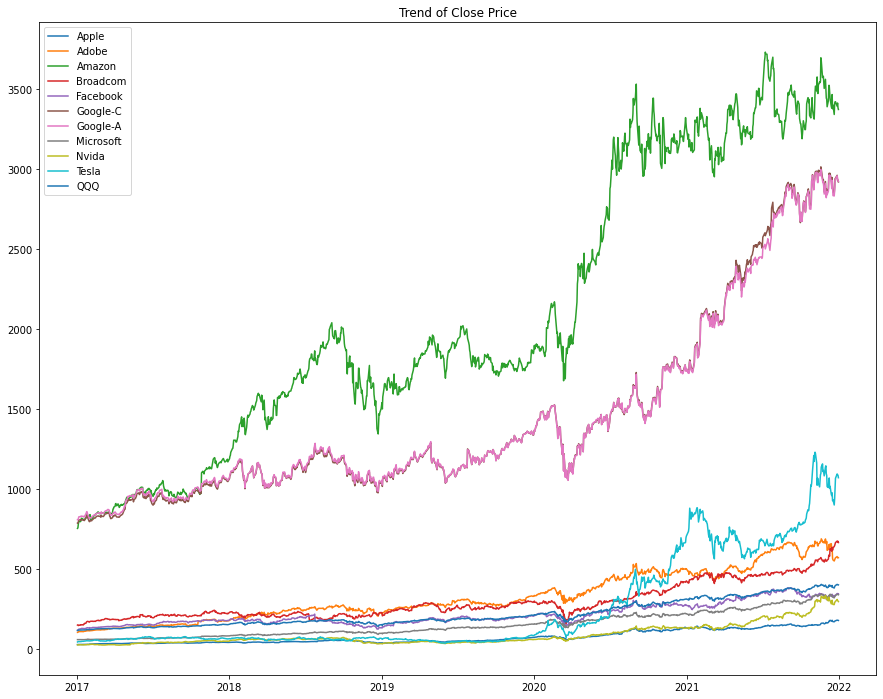

In [5]:
plot_close_price(close_df, qqq_df)

In [6]:
close_df

,Apple,Adobe,Amazon,Broadcom,Facebook,Google-C,Google-A,Microsoft,Nvida,Tesla
Date,,,,,,,,,,
2017-01-03,27.297689,103.480003,753.669983,149.425888,116.860001,786.140015,808.010010,58.065449,25.170738,43.397999
2017-01-04,27.267139,104.139999,757.179993,148.361832,118.690002,786.900024,807.770020,57.805649,25.757998,45.397999
2017-01-05,27.405798,105.910004,780.450012,146.024155,120.669998,794.020020,813.020020,57.805649,25.104113,45.349998
2017-01-06,27.711327,108.300003,795.989990,147.959641,123.410004,806.150024,825.210022,58.306698,25.439693,45.801998
2017-01-09,27.965158,108.570000,796.919983,148.277985,124.900002,806.650024,827.179993,58.121128,26.471098,46.256001
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,176.055695,569.619995,3421.370117,664.799988,335.239990,2942.850098,2938.330078,333.999390,296.399994,1067.000000
2021-12-27,180.100540,577.679993,3393.389893,674.280029,346.179993,2961.280029,2958.129883,341.743378,309.450012,1093.939941
2021-12-28,179.061859,569.359985,3413.219971,669.000000,346.220001,2928.959961,2933.739990,340.545837,303.220001,1088.469971


In [7]:
class PriceDataset(data.Dataset):
    def __init__(self, Xs, Ys, window_size):
        self.Xs = Xs
        self.Ys = Ys
        self.window_size = window_size

    def __getitem__(self, idx):
        xs = self.Xs[idx:idx + self.window_size]
        y = self.Ys[idx + self.window_size]
        return torch.tensor(xs, dtype=torch.float), torch.tensor(y, dtype=torch.float)

    def __len__(self):
        return len(self.Ys) - self.window_size

    def scaling(self, mean, std):
        self.Ys = (self.Ys - mean) / std
        self.mean = mean
        self.std = std


In [8]:
window_size = 5
train_split_ratio = 0.8

## split train and val set
Xs, Ys = close_df.values, qqq_df.values
num_train_row = int(len(Xs) * train_split_ratio)
Xs_train, Ys_train = Xs[:num_train_row], Ys[:num_train_row]
Xs_val, Ys_val = Xs[num_train_row:], Ys[num_train_row:]
print(Ys_train.shape, Ys_val.shape)

train_set = PriceDataset(Xs_train, Ys_train, window_size)
val_set = PriceDataset(Xs_val, Ys_val, window_size)
train_mean = train_set.Ys.mean()
train_std = train_set.Ys.std()
train_set.scaling(train_mean, train_std)
val_set.scaling(train_mean, train_std)
print("[Size] Train_Set: {} | Val_Set: {}".format(len(train_set), len(val_set)))


(1006, 1) (252, 1)
[Size] Train_Set: 1001 | Val_Set: 247


## 3. Build LSTM model

In [9]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMNet, self).__init__()
        self.norm1 = nn.BatchNorm1d(input_size) # [n_batch, input_size]
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True, 
        )
        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, Xs): # Xs : [n_batch, window_size, input_size]
        Xs = self.norm1(Xs.flatten(0, 1)).reshape(Xs.shape) #  batchnorm1d([n_batch * window_size, input_size]) => reshape into [n_batch, window_size, input_size]
        rnn_out, _ = self.lstm(Xs) # rnn_out: [n_batch, window_size, hidden_size]
        ## torch.sum(rnn_out, dim=1) # [n_batch, hidden_size]
        out = self.regressor(rnn_out[:, -1]) # batch first
        return out

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size, hidden_size, num_layers, dropout = 10, 64, 2, 0.2
lstm_net = LSTMNet(input_size, hidden_size, num_layers, dropout)
lstm_net.to(device)
summary(lstm_net, torch.rand(4, 10, 10).to(device))


            Kernel Shape Output Shape  Params  Mult-Adds
Layer                                                   
0_norm1             [10]     [40, 10]      20         10
1_lstm                 -  [4, 10, 64]   52736      51712
2_regressor      [64, 1]       [4, 1]      65         64
--------------------------------------------------------
                      Totals
Total params           52821
Trainable params       52821
Non-trainable params       0
Mult-Adds              51786


/opt/anaconda3/lib/python3.9/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_norm1,[10],"[40, 10]",20,10
1_lstm,-,"[4, 10, 64]",52736,51712
2_regressor,"[64, 1]","[4, 1]",65,64


In [27]:
def train_epoch(net, optimizer, loss_fn, dataloader, epoch, writer=None, device='cpu'):
    ep_loss = 0.0
    num_iter = len(dataloader)
    net.train()
    grad_max = 100.
    for n_iter, (xs, y) in enumerate(tqdm(dataloader)):
        curr_iter = epoch * num_iter + n_iter
        xs, y = xs.to(device), y.to(device)
        pred = net(xs) ## step 1. get output
        loss = loss_fn(pred, y) ## step 2. compute loss
        optimizer.zero_grad()
        loss.backward() ## step 3. backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), grad_max) ## L2-norm gradient clipping
        optimizer.step() ## step 4. update model weigth
        if writer is not None:
            writer.add_scalar('Loss/train', loss.data, curr_iter)
        # print("\n[ITER %d] LOSS: %.4f" % (curr_iter, loss.data))
        ep_loss += loss.data
    ep_loss /= len(dataloader)
    if writer is not None:
        writer.add_scalar('EpLoss/train', ep_loss, epoch)
    print("\n[EP %d] Train LOSS: %.4f" % (epoch, ep_loss))
    return ep_loss

@torch.no_grad()
def val_epoch(net, loss_fn, dataloader, epoch, val_set, writer=None, device='cpu'):
    ep_loss = 0.0
    net.eval()
    preds, ys = [], []
    for n_iter, (xs, y) in enumerate(tqdm(dataloader)):
        xs, y = xs.to(device), y.to(device)
        pred = net(xs)
        loss = loss_fn(pred, y)
        ep_loss += loss.data
        preds.append(pred.squeeze())
        ys.append(y)
    ep_loss /= len(dataloader)
    print("\n[EP %d] Val LOSS: %.4f" % (epoch, ep_loss))

    preds = torch.stack(preds).squeeze()
    ys = torch.stack(ys).squeeze()
    # if (epoch + 1) % 5 == 0:
    ## denormalize
    preds = preds * val_set.std + val_set.mean
    ys = ys * val_set.std + val_set.mean

    ## plot the prediction and GT close value
    plt.plot(ys.cpu().numpy(), label='GT')
    plt.plot(preds.cpu().numpy(), label='pred')
    plt.title("[Ep %d] GT vs Pred"%(epoch))
    plt.legend()
    plt.show()

    if writer is not None:
        writer.add_scalar('EpLoss/val', ep_loss, epoch)
    return ep_loss

def train_main(net, train_set, val_set, loss_fn, batch_size, lr, n_epoch):
    train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = data.DataLoader(val_set, batch_size=1)

    writer = None
    save_dir = './'
    # writer = SummaryWriter(log_dir=osp.join(save_dir, 'log'))
    device = 'cpu' if not torch.cuda.is_available() else 'cuda'
    net = net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    train_ep_losses, val_ep_losses = [], []
    for epoch in range(n_epoch):
        train_loss = train_epoch(net, optimizer, loss_fn, train_loader, epoch, writer, device)
        val_loss = val_epoch(net, loss_fn, val_loader, epoch, val_set, writer, device)
        train_ep_losses.append(train_loss)
        val_ep_losses.append(val_loss)
        if (epoch + 1) % 5 == 0:
            os.makedirs(osp.join(save_dir, 'weights'), exist_ok=True)
            torch.save(net.state_dict(), osp.join(save_dir, 'weights/ep%d.pth' % (epoch + 1)))
    
    plt.plot(torch.tensor(train_ep_losses).cpu().numpy(), label='train')
    plt.plot(torch.tensor(val_ep_losses).cpu().numpy(), label='val')
    plt.xlabel('n_epoch')
    plt.legend()
    plt.show()

## 4. Model Training & prediction

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 256.64it/s]



[EP 0] Train LOSS: 0.3076


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3817.50it/s]



[EP 0] Val LOSS: 1.2706


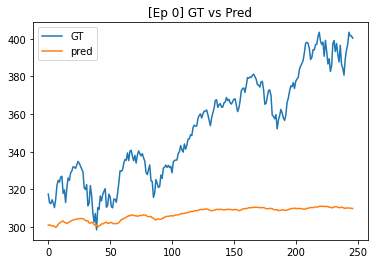

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 295.84it/s]



[EP 1] Train LOSS: 0.0707


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3219.63it/s]



[EP 1] Val LOSS: 1.6275


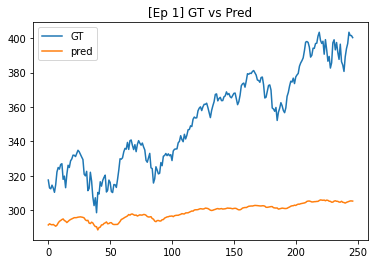

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 294.63it/s]



[EP 2] Train LOSS: 0.0565


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3229.65it/s]



[EP 2] Val LOSS: 1.3612


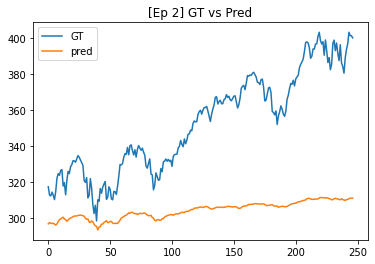

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.45it/s]



[EP 3] Train LOSS: 0.0586


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3263.83it/s]



[EP 3] Val LOSS: 1.2831


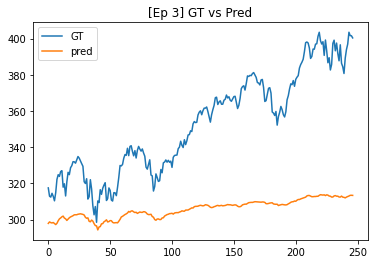

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 291.03it/s]



[EP 4] Train LOSS: 0.0452


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3321.27it/s]



[EP 4] Val LOSS: 1.2980


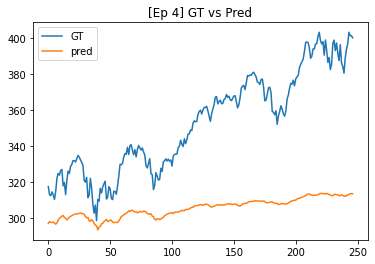

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 296.84it/s]



[EP 5] Train LOSS: 0.0441


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3211.05it/s]



[EP 5] Val LOSS: 1.2658


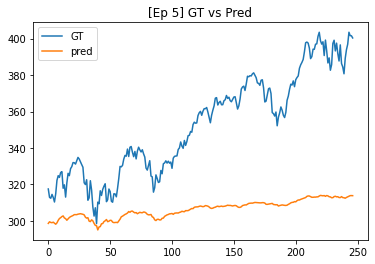

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.85it/s]



[EP 6] Train LOSS: 0.0588


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3453.48it/s]



[EP 6] Val LOSS: 1.5272


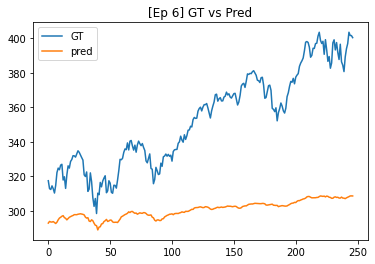

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.76it/s]



[EP 7] Train LOSS: 0.0649


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3339.18it/s]



[EP 7] Val LOSS: 1.2837


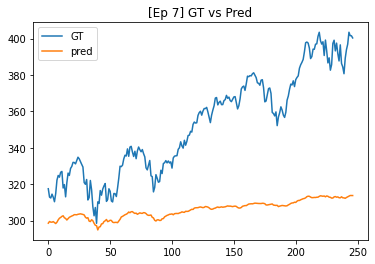

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 305.85it/s]



[EP 8] Train LOSS: 0.0371


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3365.45it/s]



[EP 8] Val LOSS: 1.3522


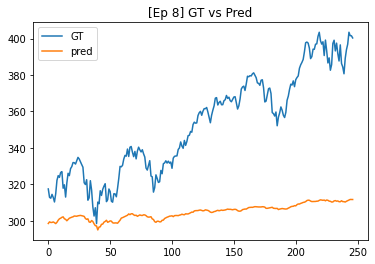

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.82it/s]



[EP 9] Train LOSS: 0.0577


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3309.44it/s]



[EP 9] Val LOSS: 1.2237


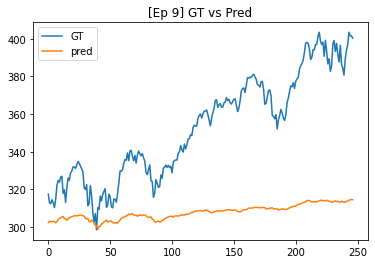

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.55it/s]



[EP 10] Train LOSS: 0.0344


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3471.97it/s]



[EP 10] Val LOSS: 1.2166


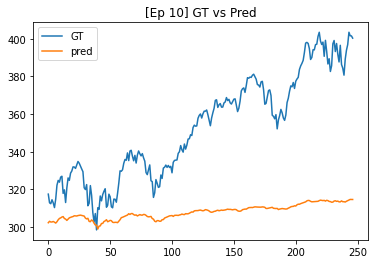

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.87it/s]



[EP 11] Train LOSS: 0.0489


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 2047.45it/s]


[EP 11] Val LOSS: 0.9692


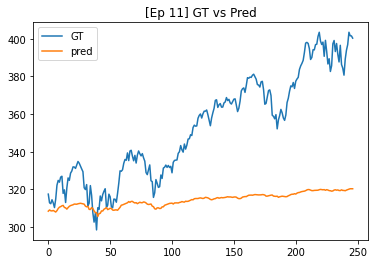

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.25it/s]



[EP 12] Train LOSS: 0.0547


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3337.66it/s]



[EP 12] Val LOSS: 1.1611


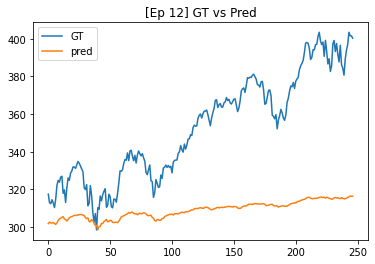

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 306.06it/s]



[EP 13] Train LOSS: 0.0388


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3272.43it/s]



[EP 13] Val LOSS: 1.3117


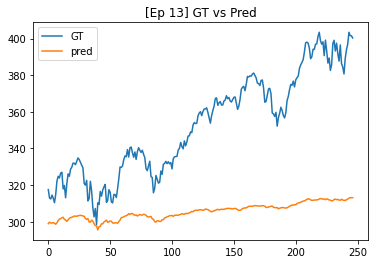

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.30it/s]



[EP 14] Train LOSS: 0.0621


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3389.22it/s]



[EP 14] Val LOSS: 1.1610


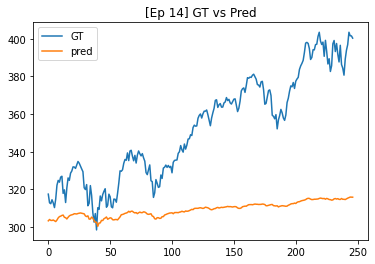

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 303.46it/s]



[EP 15] Train LOSS: 0.0439


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3268.02it/s]



[EP 15] Val LOSS: 1.3273


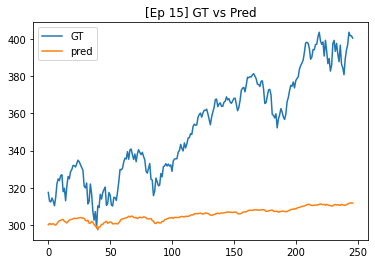

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 307.46it/s]



[EP 16] Train LOSS: 0.0417


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3323.96it/s]



[EP 16] Val LOSS: 1.0364


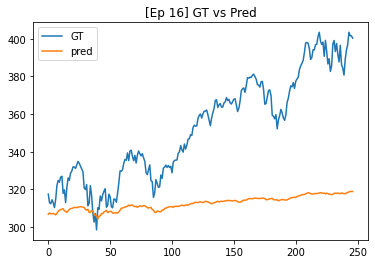

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.55it/s]



[EP 17] Train LOSS: 0.0523


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3300.72it/s]



[EP 17] Val LOSS: 1.2869


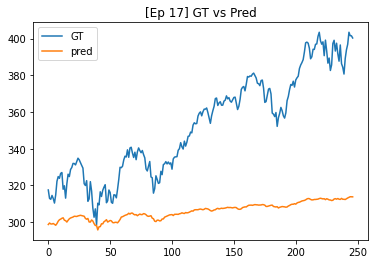

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.74it/s]



[EP 18] Train LOSS: 0.0426


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3325.97it/s]



[EP 18] Val LOSS: 1.4542


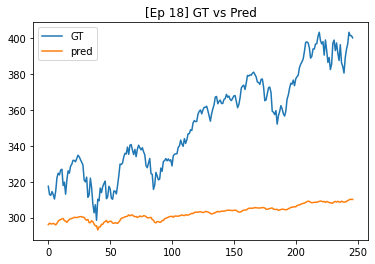

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.59it/s]



[EP 19] Train LOSS: 0.0456


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3370.51it/s]



[EP 19] Val LOSS: 1.3077


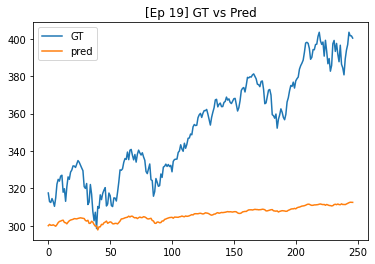

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.98it/s]



[EP 20] Train LOSS: 0.0569


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3300.08it/s]



[EP 20] Val LOSS: 1.0567


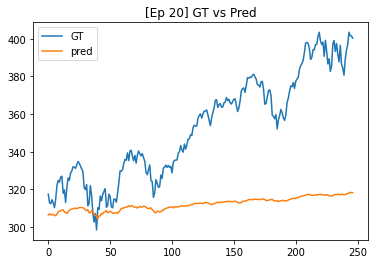

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 298.35it/s]



[EP 21] Train LOSS: 0.0499


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3478.23it/s]



[EP 21] Val LOSS: 1.4060


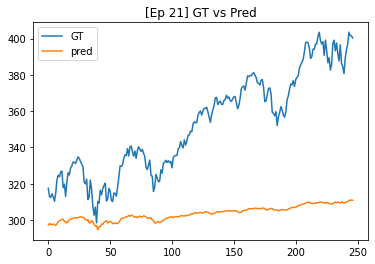

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.13it/s]



[EP 22] Train LOSS: 0.0319


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3398.64it/s]



[EP 22] Val LOSS: 1.4541


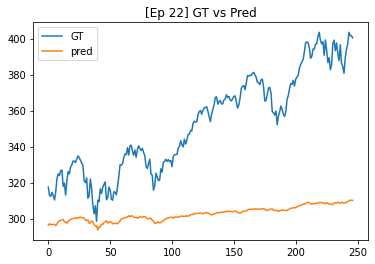

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.08it/s]



[EP 23] Train LOSS: 0.0524


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3351.51it/s]



[EP 23] Val LOSS: 1.3352


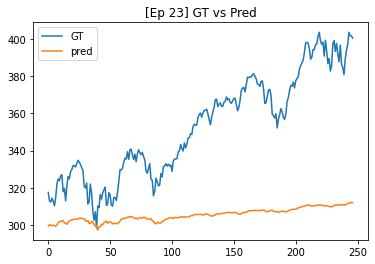

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 303.42it/s]



[EP 24] Train LOSS: 0.0404


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3312.72it/s]



[EP 24] Val LOSS: 1.1944


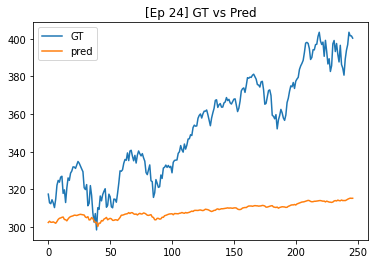

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.34it/s]



[EP 25] Train LOSS: 0.0419


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3480.57it/s]



[EP 25] Val LOSS: 1.2398


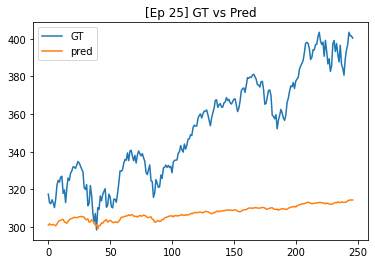

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 305.60it/s]



[EP 26] Train LOSS: 0.0430


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3470.99it/s]



[EP 26] Val LOSS: 1.1388


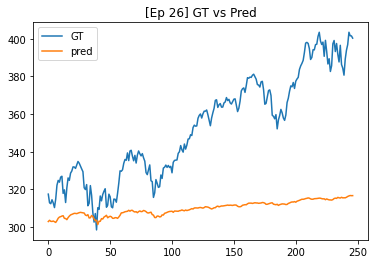

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 295.58it/s]



[EP 27] Train LOSS: 0.0418


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 2043.11it/s]


[EP 27] Val LOSS: 1.2527


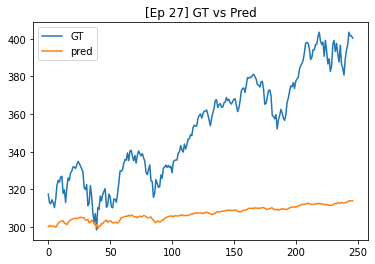

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 297.19it/s]



[EP 28] Train LOSS: 0.0379


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3282.17it/s]



[EP 28] Val LOSS: 1.3302


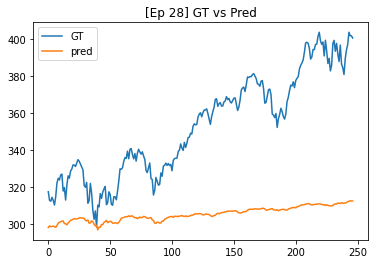

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 298.86it/s]



[EP 29] Train LOSS: 0.0293


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3332.25it/s]



[EP 29] Val LOSS: 1.2577


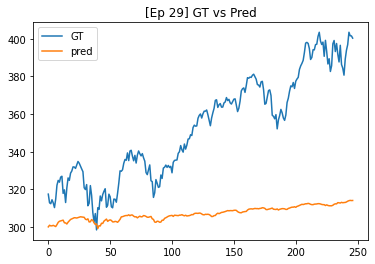

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.86it/s]



[EP 30] Train LOSS: 0.0425


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3384.45it/s]



[EP 30] Val LOSS: 1.1179


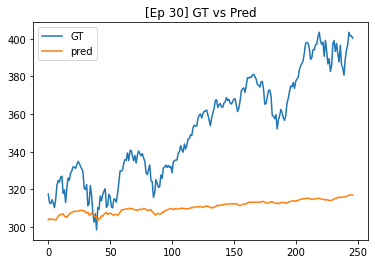

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 300.90it/s]



[EP 31] Train LOSS: 0.0326


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3369.76it/s]



[EP 31] Val LOSS: 0.9835


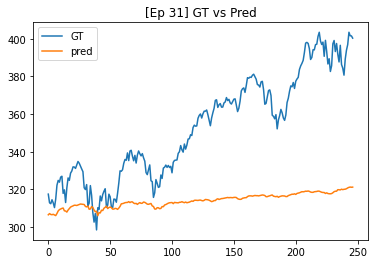

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 307.39it/s]



[EP 32] Train LOSS: 0.0435


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3423.80it/s]



[EP 32] Val LOSS: 1.1092


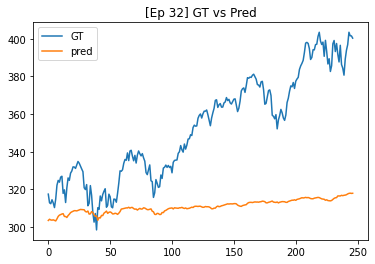

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.28it/s]



[EP 33] Train LOSS: 0.0272


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3533.51it/s]



[EP 33] Val LOSS: 1.1056


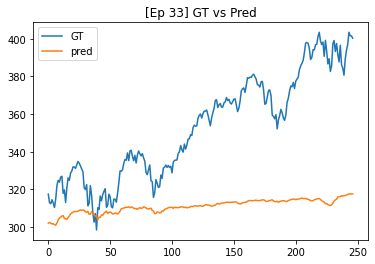

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 299.98it/s]



[EP 34] Train LOSS: 0.0444


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3243.40it/s]



[EP 34] Val LOSS: 0.8698


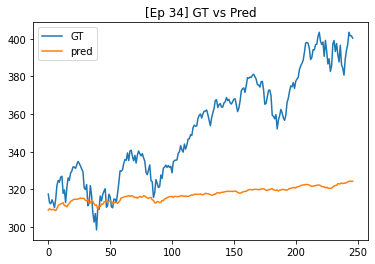

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 306.01it/s]



[EP 35] Train LOSS: 0.0309


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3339.33it/s]



[EP 35] Val LOSS: 1.0534


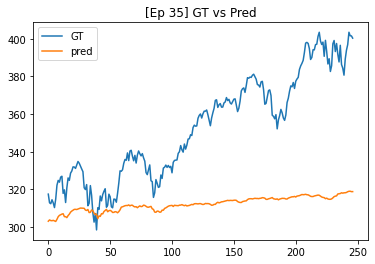

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 303.50it/s]



[EP 36] Train LOSS: 0.0336


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3437.34it/s]



[EP 36] Val LOSS: 1.0277


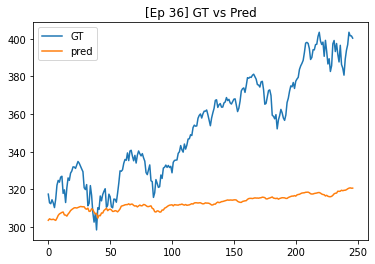

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.27it/s]



[EP 37] Train LOSS: 0.0412


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3377.54it/s]



[EP 37] Val LOSS: 0.9021


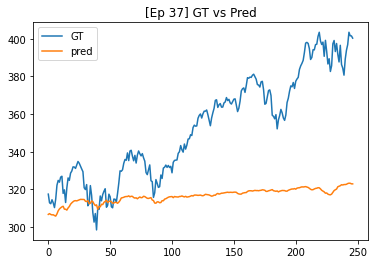

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 306.77it/s]



[EP 38] Train LOSS: 0.0381


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3365.26it/s]



[EP 38] Val LOSS: 1.0135


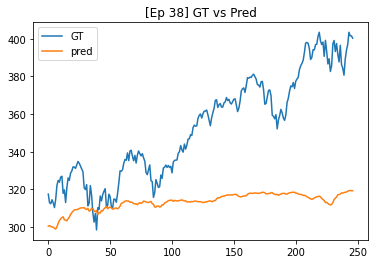

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.17it/s]



[EP 39] Train LOSS: 0.0303


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3345.22it/s]



[EP 39] Val LOSS: 0.8795


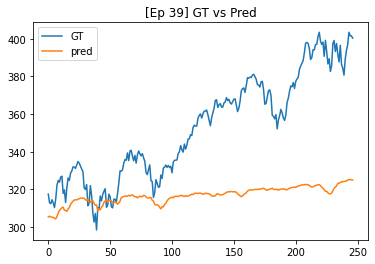

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.07it/s]



[EP 40] Train LOSS: 0.0268


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3400.75it/s]



[EP 40] Val LOSS: 0.8590


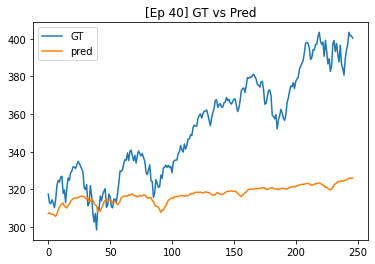

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.05it/s]



[EP 41] Train LOSS: 0.0271


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3372.66it/s]



[EP 41] Val LOSS: 0.7913


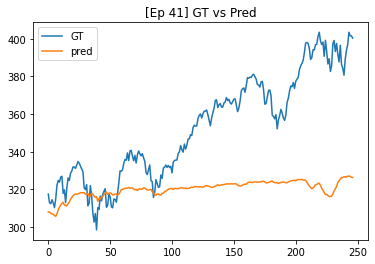

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.72it/s]



[EP 42] Train LOSS: 0.0265


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3367.19it/s]



[EP 42] Val LOSS: 0.8959


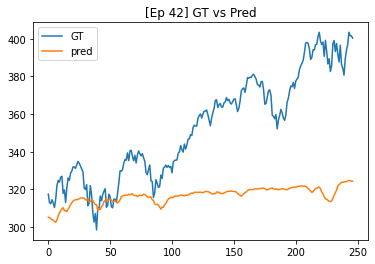

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.61it/s]



[EP 43] Train LOSS: 0.0296


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 2050.47it/s]


[EP 43] Val LOSS: 1.0347


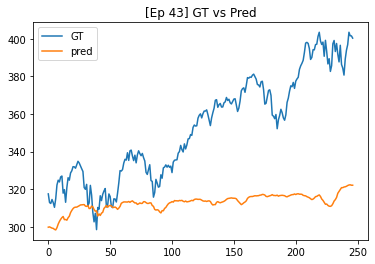

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.70it/s]



[EP 44] Train LOSS: 0.0310


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3381.30it/s]



[EP 44] Val LOSS: 1.0509


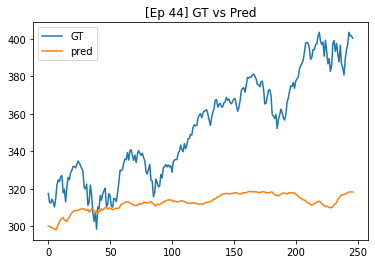

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 298.42it/s]



[EP 45] Train LOSS: 0.0286


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3256.05it/s]



[EP 45] Val LOSS: 0.9415


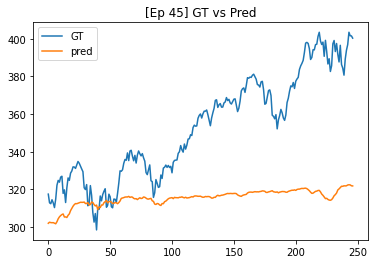

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.40it/s]



[EP 46] Train LOSS: 0.0294


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3576.92it/s]



[EP 46] Val LOSS: 0.7610


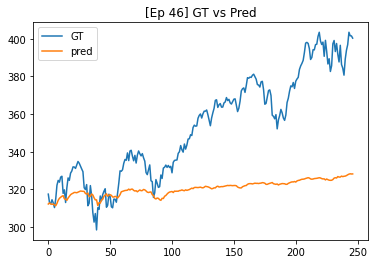

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 301.60it/s]



[EP 47] Train LOSS: 0.0388


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3324.13it/s]



[EP 47] Val LOSS: 1.2425


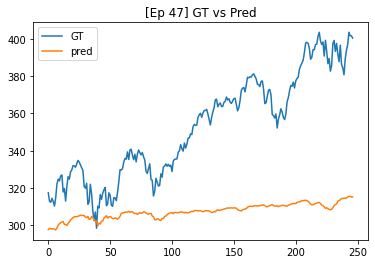

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 304.57it/s]



[EP 48] Train LOSS: 0.0271


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3341.14it/s]



[EP 48] Val LOSS: 1.0140


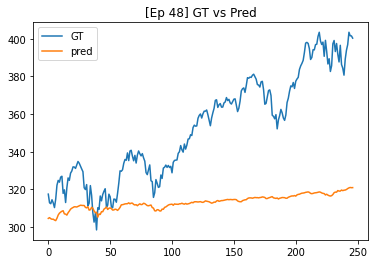

100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 302.21it/s]



[EP 49] Train LOSS: 0.0380


100%|█████████████████████████████████████████████████| 247/247 [00:00<00:00, 3360.04it/s]



[EP 49] Val LOSS: 1.0328


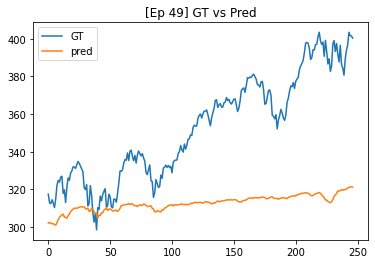

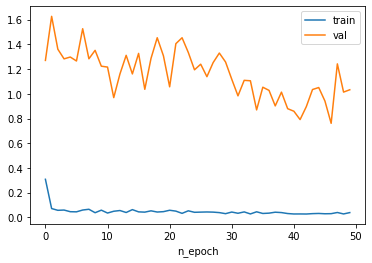

In [28]:
input_size, hidden_size, num_layers, dropout = 10, 64, 1, 0.2
net = LSTMNet(input_size, hidden_size, num_layers, dropout)
loss_fn = nn.MSELoss()
batch_size, n_epoch, lr = 32, 50, 1e-3

a = train_main(net, train_set, val_set, loss_fn, batch_size, lr, n_epoch)


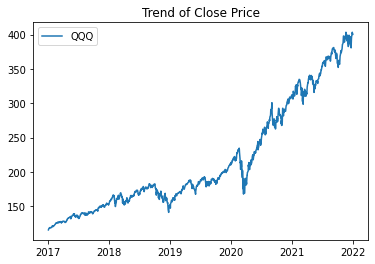

In [30]:

plt.plot(qqq_df, label='QQQ')
plt.title('Trend of Close Price')
#plt.xticks(rotation=100)
plt.legend()
plt.show()